# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

In [2]:
# Divide up into cars and notcars
images = glob.glob('data/*/*/*.png')
vehicles = []
notvehicles = []
for image in images:
    if 'non-vehicles' in image:
        notvehicles.append(image)
    elif 'vehicles' in image:
        vehicles.append(image)
    else:
        print("error")

In [3]:
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
ORIENT = 9

# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys', transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        
        return features, hog_image
    
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys', transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        
        return features

In [5]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        
        # use png image
        image = mpimg.imread(file)
        # image = (image*255).astype(np.uint8) # 0-1 float32 to 0-255 uint8
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                 orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.hstack((hog_features))
        
        # Get color features
        spatial_features = bin_spatial(feature_image)
        hist_features = color_hist(feature_image)

        # Scale features and make a prediction
        stacked = np.hstack((spatial_features, hist_features, hog_features))
        
        features.append(stacked)
        
    # Return list of feature vectors
    return features

In [7]:
orient = ORIENT
pix_per_cell = PIX_PER_CELL
cell_per_block = CELL_PER_BLOCK

t=time.time()
car_features = extract_features(vehicles, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

notcar_features = extract_features(notvehicles, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

133.05 Seconds to extract HOG features...


In [8]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
np.random.seed(10)
rand_state = np.random.randint(0, 100) 
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [41]:
"""from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import pprint
# Grid Search for SVM
svc = SVC()
parameters = [{
    'C' : [x/10 for x in list(range(2, 20, 2))],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}]

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_test, y_test)

print("best parameter:{}".format(clf.best_params_))
mean_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['mean_test_score']]
std_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['std_test_score']]
pprint.pprint(list(zip(mean_test_score, std_test_score, clf.cv_results_['params'])))"""

KeyboardInterrupt: 

In [9]:
from sklearn.model_selection import GridSearchCV
import pprint
# Grid Search for SVM
svc = LinearSVC()
parameters = [{
    'C' : [x/10 for x in list(range(2, 20, 2))],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2']
}]

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_test, y_test)

print("best parameter:{}".format(clf.best_params_))
mean_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['mean_test_score']]
std_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['std_test_score']]
pprint.pprint(list(zip(mean_test_score, std_test_score, clf.cv_results_['params'])))

best parameter:{'penalty': 'l2', 'C': 0.2, 'loss': 'hinge'}
[('0.980011', '0.005141', {'C': 0.2, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.2, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.4, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.4, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.6, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.6, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.8, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.8, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 1.0, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 1.2, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 1.2, 'loss': 'squared_hinge', 'penalty': 'l2'}),
 ('0.980011', '0

In [10]:
svc = LinearSVC()
parameters = [{
    'C' : [x/100 for x in list(range(1, 30, 3))],
    'loss': ['hinge'],
    'penalty': ['l2']
}]

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_test, y_test)

print("best parameter:{}".format(clf.best_params_))
mean_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['mean_test_score']]
std_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['std_test_score']]
pprint.pprint(list(zip(mean_test_score, std_test_score, clf.cv_results_['params'])))

best parameter:{'penalty': 'l2', 'C': 0.01, 'loss': 'hinge'}
[('0.980011', '0.005141', {'C': 0.01, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.04, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.07, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.13, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.16, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.19, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.22, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.25, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.980011', '0.005141', {'C': 0.28, 'loss': 'hinge', 'penalty': 'l2'})]


In [11]:
svc = LinearSVC()
parameters = [{
    'C' : [x/10000 for x in list(range(1, 10, 1))],
    'loss': ['hinge'],
    'penalty': ['l2']
}]

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_test, y_test)

print("best parameter:{}".format(clf.best_params_))
mean_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['mean_test_score']]
std_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['std_test_score']]
pprint.pprint(list(zip(mean_test_score, std_test_score, clf.cv_results_['params'])))

best parameter:{'penalty': 'l2', 'C': 0.0004, 'loss': 'hinge'}
[('0.976633', '0.004757', {'C': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.977759', '0.004483', {'C': 0.0002, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.978604', '0.004481', {'C': 0.0003, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.979167', '0.004653', {'C': 0.0004, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.979167', '0.004567', {'C': 0.0005, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.978322', '0.003620', {'C': 0.0006, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.978604', '0.003370', {'C': 0.0007, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.978885', '0.004615', {'C': 0.0008, 'loss': 'hinge', 'penalty': 'l2'}),
 ('0.978322', '0.004748', {'C': 0.0009, 'loss': 'hinge', 'penalty': 'l2'})]


In [12]:
# Use a linear SVC
svc = LinearSVC(C=clf.best_params_['C'], loss=clf.best_params_['loss'], penalty=clf.best_params_['penalty'])

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

6.55 Seconds to train SVC...
Test Accuracy of SVC =  0.9873
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
0.00215 Seconds to predict 10 labels with SVC


In [ ]:
testdata = {'Car': 'test_images/car.png', 'Notcar': 'test_images/road.png'}

hog_imgs = []
Ych = []
for label, img in testdata.items():
    img = mpimg.imread(img)

    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    chf = feature_image[:,:,0]
    Ych.append(chf)
    feature, hog_img = get_hog_features(chf, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    
    hog_imgs.append(hog_img)
    
fontsize = 10
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6))
f.tight_layout()
ax1.imshow(mpimg.imread(testdata['Car']))
ax1.set_title('Car', fontsize=fontsize)
ax2.imshow(Ych[0])
ax2.set_title('Ch1 Feature', fontsize=fontsize)
ax3.imshow(hog_imgs[0])
ax3.set_title('Hog', fontsize=fontsize)

ax4.imshow(mpimg.imread(testdata['Notcar']))
ax4.set_title('NotCar', fontsize=fontsize)
ax5.imshow(Ych[1])
ax5.set_title('Ch1 Feature', fontsize=fontsize)
ax6.imshow(hog_imgs[1])
ax6.set_title('Hog', fontsize=fontsize)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

array([ 0.])

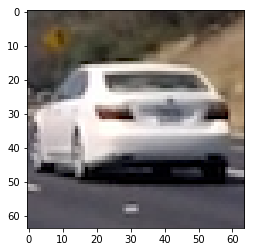

In [40]:
orient = ORIENT
pix_per_cell = PIX_PER_CELL
cell_per_block = CELL_PER_BLOCK

test_image = ["test_images/car.png"]
test_image_feature = extract_features(test_image, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

features = X_scaler.transform(test_image_feature[0].reshape(1, -1))    

# 1 == car , 0 == not car
plt.imshow(mpimg.imread(test_image[0]))
svc.predict(features)

array([ 0.])

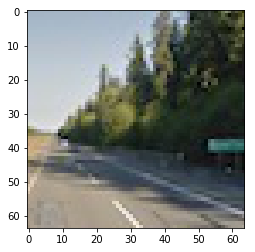

In [14]:
orient = ORIENT
pix_per_cell = PIX_PER_CELL
cell_per_block = CELL_PER_BLOCK

test_image = ["test_images/road.png"]
test_image_feature = extract_features(test_image, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
features = X_scaler.transform(test_image_feature[0].reshape(1, -1))    

plt.imshow(mpimg.imread(test_image[0]))
svc.predict(features)

# Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [36]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, spatial_size=(32, 32), hist_bins=32):
    
    car_boxes = []
    # jpg image
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    img_tosearch = img_tosearch.astype(np.float32)/255.0

    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            stacked = np.hstack((spatial_features, hist_features, hog_features))

            test_features = X_scaler.transform(stacked.reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                car_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_boxes
    #return draw_img

In [ ]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

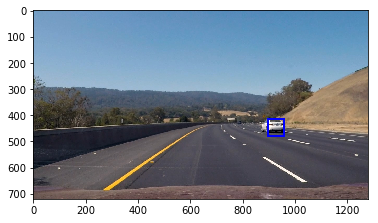

In [35]:
ystart = 400
ystop = 656
scale = 1.0

img = mpimg.imread('test_images/test3.jpg')
car_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler)
plt.imshow(car_boxes)
# plt.savefig('YCrCb_PIX_PER_CELL8_CELL_PER_BLOCK2_ORIENT9_adjust_range1.png',  bbox_inches="tight", dpi=200)

In [ ]:
# Plot heatmap
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat, car_boxes)

plt.pcolor(heat, cmap=plt.cm.Blues)
plt.set_title('Heatmap')

In [29]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels, svc):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        prob = svc.predict_proba(img[bbox[0][0]:bbox[0][1], bbox[1][0]:bbox[1][1]])[0]
        # Draw probability of sub image
        cv2.putText(img, prob, bbox[0], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3, cv2.LINE_AA)

        
    # Return the image
    return img

In [ ]:
img = mpimg.imread('test_images/test5.jpg')
heat = np.zeros_like(img[:,:,0]).astype(np.float)

heat = add_heat(heat, car_boxes)
heat = apply_threshold(heat,3)
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels, svc)
plt.imshow(draw_img)

In [37]:
# scv : 
# X_scaler : 

def pipeline(image):
    ystart = 400
    ystop = 656
    scale = 1.0

    car_boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    heat = add_heat(heat, car_boxes)
    heat = apply_threshold(heat,0)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels, svc)
    
    return draw_img

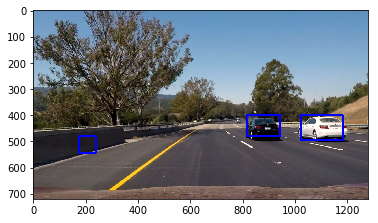

In [38]:
img_list = glob.glob('test_images/test*.jpg')

for index, img in enumerate(img_list):
    test_image = mpimg.imread(img)
    plotted = pipeline(test_image)
    
    plt.imshow(plotted)
    plt.savefig("result/"+img.split('/')[-1], bbox_inches="tight", dpi=200)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'result_project_video_tuned.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)